# TAREA I - SEP I/A
<div style="text-align: justify;">

## 0. Esquema De Arquitectura Del Proyecto
Se presenta un breve esquema realizado en la aplicación Drawio que resume a grandes rasgos la forma de operación en que se realiza el estudio y proyecto presentado en este informe. En el que dos estudiantes pueden intercambiar conocimiento a través de la plataforma GitHub.

<div style="text-align: center;">
  <img src="IMAGENES/Esquema_Proyecto.PNG" alt="Descripción de la imagen" width="500"/>
</div>

## 1. Estudio De Ingeniería

### I. Terminología
* **SEN:** Sistema Eléctrico Nacional.
* **ST:** Sistema De Transmisión.
* **CC:** Centro de Control de un Coordinado.

### II. Límites Admisibles de Operación
En base a lo mencionado por la "Norma Técnica de Seguridad y Calidad de Servicio" [1], se definen a continuación los límites admisibles de operación para el estudio.

**A) Estándares de Instalaciones del SEN Para Estado Normal, Estado De Alerta y Estado de Emergencia.**

**[Artículo 5-19]** El SI deberá operar en Estado Normal con todos los elementos e instalaciones del ST y compensación de potencia reactiva disponibles, y suficientes márgenes y reserva de potencia reactiva en las unidades generadoras, compensadores estáticos y sincrónicos, para lo cual el Coordinador y los CC, según corresponda, deberán controlar que la magnitud de la tensión en las barras del SI esté comprendida entre:
* 0.97 y 1.03 pu, para instalaciones del ST con tensión nominal igual o superior a 500 [kV].
* 0.95 y 1.05 pu, para instalaciones del ST con tensión nominal igual o superior a 200 [kV] e inferior a 500 [kV].
* 0.93 y 1.07 pu para instalaciones del ST con tensión nominal inferior a 200 [kV].

**[Artículo 5-23]** En Estado de Alerta el Coordinador y los CC deberán controlar que la magnitud de la tensión en
las barras del SI esté comprendida entre:
* 0.95 y 1.05 pu, para instalaciones del Sistema de Transmisión con tensión nominal igual o superior a 500 [kV], siempre que el límite superior no exceda la tensión máxima de servicio de los equipos.
* 0.93 y 1.07 pu, para instalaciones del Sistema de Transmisión con tensión nominal igual o superior a 200 [kV] e inferior a 500 [kV], siempre que el límite superior no exceda la tensión máxima de servicio de los equipos.
* 0.90 y 1.10 pu, para instalaciones del Sistema de Transmisión con tensión nominal inferior a 200 [kV], siempre que el límite superior no exceda la tensión máxima de servicio de los equipos.

**[Artículo 5-47]** En Estado de Emergencia el Coordinador y los CC deberán controlar que la magnitud de la tensión
en las barras del SI esté comprendida entre:
* 0.93 y 1.05 pu, para instalaciones del Sistema de Transmisión con tensión nominal igual o superior a 500 [kV], siempre que el límite superior no exceda la tensión máxima de servicio de los equipos.
* 0.90 y 1.10 por unidad, para instalaciones del Sistema de Transmisión con tensión nominal igual o superior a 200 [kV] e inferior a 500 [kV], siempre que el límite superior no exceda la tensión máxima de servicio de los equipos.
* 0.90 y 1.10 por unidad, para instalaciones del Sistema de Transmisión con tensión nominal inferior a 200 [kV], siempre que el límite superior no exceda la tensión máxima de servicio de los equipos.

### III. Tipos de Modelados De Líneas
En general, para la modelación de líneas de transmisión existen dos enfoques: en primer lugar se tiene el modelamiento a través de **parámetros concentrados**, en el que la línea se modela como una serie de componentes concentrados distribuidos a lo largo de su longitud, basándose en la simplificación de la línea como un circuito equivalente, donde cada componente representa una característica eléctrica específica de la línea. Mientras que por otro lado, el segundo enfoque involucra el modelamiento de líneas a través de **parámetros distribuidos**, en el que la línea se modela como un circuito distribuido, y por lo tanto, donde los parámetros eléctricos varían continuamente a lo largo de la longitud de la línea. De manera que en lugar de utilizar componentes discretos (RLC), se utilizan funciones de distribución para representar la variación continua de estos parámetros.

Así entonces, mientras el modelado a través de **parámetros concentrados** es útil para análisis de circuitos de corriente alterna (AC) y para aplicaciones donde la longitud de la línea es relativamente corta en comparación con la longitud de onda de la señal, el modelado a través de **parámetros distribuidos** representa un enfoque mucho más preciso para modelar líneas de transmisión largas o para frecuencias más altas donde los efectos de distribución son significativos.

Respecto a la librería escogida para este estudio, se debe señalar que corresponde a la librería **PandaPower**. La cual trabaja directamente el modelado de líneas a través del uso de _parámetros concentrados_.
</div>

## 2. MODELO A

En base a la información suministrada para el **Sistema A** y mostrada en la figura se plantea el esquema con Panda Power. Y se realiza el flujo de carga respectivo para la carga que cambia en el rango $\pm 50\%$ de la potencia indicada.

<div style="text-align: center;">
  <img src="IMAGENES/MODELO_A.PNG" alt="Descripción de la imagen" width="200"/>
</div>

**OBSERVACIÓN:** Puesto que la carga posee un rango de operación, se calcula previamente este rango de la siguiente manera:

  $$Rango\ Carga = [1200 \times 0.5\ \text{MVA},\ 1200 \times 1.5\ \text{MVA}] = [600\ \text{MVA},\ 1800\ \text{MVA}]$$

In [166]:
#Variables Globales
Tensiones = []
LineasP = []
Compensador = []
Paso = 100 #MVA
max_iteraciones = 20

In [119]:
print(Tensiones)

[1.086900610081404]


In [167]:
import pandapower as pp
import math as mm
import matplotlib.pyplot as plt
import numpy as np
import cmath as cm

#Parámetros de Línea
r1 = 0.02  #(Ohm/km)
x1 = 0.115 #(Ohm/km)
B1 = 19.1  #(nF/km)
Imax1 = 1  #(kA)
#Parametros Matriz
A = 0.9561 + 0.00763j
B = 10.3454 + 54.4858j
cont = 0 #(600,1800+1,Paso)
for i in range(600,601): 
    net1 = pp.create_empty_network()
    #Barras
    b1_1 = pp.create_bus(net1, vn_kv=1200, name="Barra 1")
    b2_1 = pp.create_bus(net1, vn_kv=1200, name="Barra 2")
    #Calculo De Potencias En Carga
    FP1 = 0.9
    P1 = round(i * FP1, 2)
    Q1 = round(i * mm.sqrt(1 - FP1**2), 2)
    #Elementos De Barra
    pp.create_ext_grid(net1, bus=b1_1, vm_pu=1.00, name="Fuente Externa")
    pp.create_load(net1, bus=b2_1, p_mw=P1, q_mvar=Q1, name="Carga 1")
    pp.create_shunt(net1, bus=b2_1, p_mw=None, q_mvar=-2057.15, name="shunt")
    #print(round(Compensador[cont],4))
    #LINEAS
    pp.create_line_from_parameters(net1, name='Linea 1-2_1', length_km=500, from_bus=b1_1, to_bus=b2_1,
                                   r_ohm_per_km=r1, x_ohm_per_km=x1, c_nf_per_km=B1, max_i_ka=Imax1)
    pp.create_line_from_parameters(net1, name='Linea 1-2_2', length_km=500, from_bus=b1_1, to_bus=b2_1,
                                   r_ohm_per_km=r1, x_ohm_per_km=x1, c_nf_per_km=B1, max_i_ka=Imax1)
    #Flujo De Energía
    pp.runpp(net1,max_iteration=max_iteraciones)
    tension_barra2 = net1.res_bus.at[1,'vm_pu']
    perdidaL = net1.res_line.loc[0, 'pl_mw']
    Tensiones.append(tension_barra2)
    LineasP.append(perdidaL*2)
    if i ==600:
        print(net1.res_bus)
    #Calculo De Compensación Shunt
    #Vnorma= 1.0
    #deltaV = abs(tension_barra2-Vnorma)
    #por_shunt= -1*deltaV*net1.res_bus.at[0, 'p_mw'] / net1.res_bus.at[0, 'q_mvar']
    #print(por_shunt)
    #Compensador.append(por_shunt)
    cont = cont + 1

c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\pandapower\pf\create_jacobian.py:28: RuntimeWarning: invalid value encountered in divide
  dVm_x, dVa_x = dSbus_dV_numba_sparse(Ybus.data, Ybus.indptr, Ybus.indices, V, V / abs(V), Ibus)
c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\pandapower\pypower\newtonpf.py:337: MatrixRankWarning: Matrix is exactly singular
  dx = -1 * spsolve(J, F, permc_spec=permc_spec, use_umfpack=use_umfpack)


LoadflowNotConverged: Power Flow nr did not converge after 20 iterations!

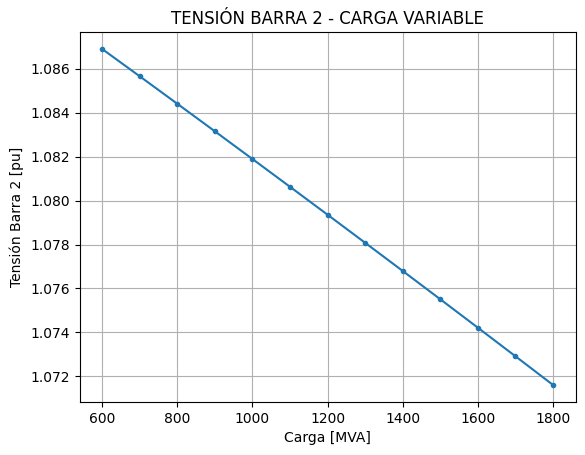

In [105]:
#A) COMPORTAMIENTO DE LA TENSIÓN PARA CARGA VARIABLE
import matplotlib.pyplot as plt
plt.plot(list(range(600,1800+1,100)), Tensiones, marker='.', linestyle='-')
plt.xlabel('Carga [MVA]')
plt.ylabel('Tensión Barra 2 [pu]')
plt.title('TENSIÓN BARRA 2 - CARGA VARIABLE')
plt.grid(True) 
plt.show()

<div style="text-align: justify;">

La gráfica obtenida de la variación de tensión en la **BARRA 2** para la carga variable conectada en el extremo receptor de la línea, muestra que a medida que el nivel de carga aumenta la tensión en el lado receptor disminuye. Esto es un resultado altamente esperable de manera teórica, puesto que con un simple análisis de la expresión para el cálculo de la potencia aparente, dada por:

$$S=V\times I^{*} \to V=\frac{S}{I^{*}}$$

Se puede determinar que al aumentar el nivel de demanda S, la corriente tambien debe aumentar y como esta es inversamente proporcional a la tensión, esta comienza a disminuir. Se ha de resaltar, que este es un hecho sumamente importante en SEP, puesto que permite dimensionar los efectos que podría provocar en los sistemas de transmisión una cantidad desproporcionada de demanda, que en un principio bajaría drásticamente las tensiones nominales de las barras de alimentación.
</div>

<div style="text-align: justify;">

Por otro lado, las tensiones de barra se encuentran muy por fuera de lo establecido por la normativa vigente, y por lo tanto, surge la idea del diseño de una compensación que permita normalizarlas a un valor aceptable. Para esto, se plantea una compensación simple (shunt) del tipo _capacitiva_ que logre elevar la tensión de la barra receptora a valores estables mencionados por la normativa para el _ESTADO NORMAL_ de operación.

Desde luego, en primera instancia se requiere formular el sistema matricial del modelo _PI-EQUIVALENTE_, lo cual se consigue de la siguiente manera para la **línea larga** de 500km:
$$z=(R+jX)=(0.02+j0.115) ~(\Omega)$$
$$y=j\omega C = j6\times 10^{-6} ~(S)$$
$$\bar{z}=(R+jX)\times\ell=(0.02+j0.115)\times 500=10+j57.5 ~(\Omega)$$
$$\bar{y}=j\omega C\times\ell=j(2\pi\times 50)(19.1\times 10^{-9})\times 500=j0.003 ~(\Omega)$$ 

Cuya correción para _línea larga_ es dada por:
$$\gamma = \sqrt{zy}= 7.196\times 10^{-5} + 8.338 \times 10^{-4} ~(1/km)$$
$$z'=\bar{z}\times f_{z}=\bar{z}\times \frac{senh(\gamma L)}{\gamma L}=10.3454+j59.4858 ~(\Omega)$$
$$y'=\frac{\bar{y}}{2}\times f_{y}=\frac{\bar{y}}{2}\times \frac{tanh(\gamma L/2)}{\gamma L/2}=j0.001475 ~(S)$$

Así entonces, se calculan los coeficientes de la matriz de línea:
$$A = D = 1+\frac{y'z'}{2}=0.9561+j0.00763 ~(-)$$
$$B=z'= 10.3454+j59.4858 ~(\Omega)$$
$$C=y'\left(1+\frac{y'z'}{4}\right)= -5.6269\times 10^{-6}+j0.00144 ~(S)$$

De esta manera, el modelo matricial de una de las líneas en paralelo, es el siguiente:
$$
\begin{equation*} 
\begin{bmatrix}
V_{S}\\
I_{S}'
\end{bmatrix}
=
\begin{bmatrix} 
A & B\\
C & D \\
\end{bmatrix}
\begin{bmatrix}
V_{R} \\
I_{R}'
\end{bmatrix}
\end{equation*} \to

\begin{equation*} 
\begin{bmatrix}
V_{S}\\
I_{S}'
\end{bmatrix}
=
\begin{bmatrix} 
 0.9561+j0.00763 & 10.3454+j59.4858\\
-5.6269\times 10^{-6}+j0.00144 & 0.9561+j0.00763 \\
\end{bmatrix}
\begin{bmatrix}
V_{R} \\
I_{R}'
\end{bmatrix}
\end{equation*} 
$$

Donde se debe notar, que debido a que el sistema está compuesto por dos líneas en paralelo, $I_{s}'$ e $I_{R}'$ corresponden a los parámetros que definen a $I_{S}/2$ e $I_{R}/2$ respectivamente. Esto, debido a que la conexión paralelo ocasiona que las tensiones a ambos extremos de las líneas sean iguales, no así las corrientes. Por lo tanto, para efectos prácticos y por temas de similitud de ambas líneas, se puede hacer el supuesto de que las corrientes se dividen en igual proporción a través de la conexión paralela.
</div>

<div style="text-align: justify;">

Desde luego, al considerar la implementación de una _compensación shunt_ en la línea del tipo capacitiva, el sistema matricial se transforma de la siguiente forma:
$$
\begin{equation*} 
\begin{bmatrix}
V_{S}\\
I_{S}'
\end{bmatrix}
=
\begin{bmatrix} 
1 & 0\\
Y_{c} & 1 \\
\end{bmatrix}
\begin{bmatrix} 
A & B\\
C & D \\
\end{bmatrix}
\begin{bmatrix} 
1 & 0\\
Y_{c} & 1 \\
\end{bmatrix}
\begin{bmatrix}
V_{R} \\
I_{R}'
\end{bmatrix}
=
\begin{bmatrix} 
A+BY_{c} & B\\
C +Y_{c}(D+BY_{c})+AY_{c}& D+BY_{c} \\
\end{bmatrix}
\begin{bmatrix}
V_{R} \\
I_{R}'
\end{bmatrix}
\end{equation*}
$$

</div>

In [ ]:
#B) 

In [ ]:
#C) PÉRDIDAS EN LA LÍNEA PARA EL RANGO DE POTENCIA DEMANDADA
import matplotlib.pyplot as plt
plt.plot(list(range(600,1800+1,100)), LineasP, marker='.', linestyle='-', label='Pérdidas Sin Compensación')
plt.xlabel('Carga [MVA]')
plt.ylabel('Pérdidas en Línea [MW]')
plt.title('PÉRDIDAS DE LÍNEA - CARGA VARIABLE')
plt.grid(True)
plt.legend() 
plt.show()

## 3. MODELO B

In [ ]:
import pandapower as pp

net2 = pp.create_empty_network()
#Carga Nominal Por Barra
P2 = 150 #MW
Q2 = 100 #MVAr
#Barras
b1 = pp.create_bus(net2, vn_kv=110, name='Barra 1')
b2 = pp.create_bus(net2, vn_kv=220, name="Barra 2")
b1A = pp.create_bus(net2, vn_kv=220, name="Barra 1A")
b2A = pp.create_bus(net2, vn_kv=220, name="Barra 2A")
b3A = pp.create_bus(net2, vn_kv=220, name="Barra 3A")
b1B = pp.create_bus(net2, vn_kv=220, name="Barra 1B")
b2B = pp.create_bus(net2, vn_kv=220, name="Barra 2B")
#Elementos De Barra
pp.create_ext_grid(net2, bus=b1, vm_pu=1.00, name="Fuente Externa")
pp.create_load(net2, bus=b1A, p_mw=P2*0.2, q_mvar=Q2*0.2, name="Carga 1A")
pp.create_load(net2, bus=b2A, p_mw=P2*0.35, q_mvar=Q2*0.35, name="Carga 2A")
pp.create_load(net2, bus=b3A, p_mw=P2*0.15, q_mvar=Q2*0.15, name="Carga 3A")
pp.create_load(net2, bus=b1B, p_mw=P2*0.1, q_mvar=Q2*0.1, name="Carga 1B")
pp.create_load(net2, bus=b2B, p_mw=P2*0.6, q_mvar=Q2*0.6, name="Carga 2B")
#Elementos De Rama
tid = pp.create_transformer(net2, hv_bus=b2, lv_bus=b1, std_type="100 MVA 220/110 kV", name="Trafo")
#L 2 - 1A
pp.create_line(net2, from_bus=b2, to_bus=b1A, length_km=10, name="Line",std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV") 
#L 1A - 2A
pp.create_line(net2, from_bus=b1A, to_bus=b2A, length_km=15, name="Line",std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV") 
#L 2A - 3A
pp.create_line(net2, from_bus=b2A, to_bus=b3A, length_km=20, name="Line",std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV") 
#L 3A - 2B
pp.create_line(net2, from_bus=b3A, to_bus=b2B, length_km=15, name="Line",std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV") 
#L 2B - 1B
pp.create_line(net2, from_bus=b2B, to_bus=b1B, length_km=30, name="Line",std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV") 
#L 1B - 2
pp.create_line(net2, from_bus=b1B, to_bus=b2, length_km=10, name="Line",std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV") 
#Flujo De Carga
pp.runpp(net2)

In [ ]:
print("Resultados de las barras:")
print(net2.res_bus)

In [ ]:
import pandapower as pp
import math as mm

#Variables Globales
Tensiones = []
Paso = 200 #MVA
max_iteraciones = 20
#Parámetros de Línea
r1 = 0.02  #(Ohm/km)
x1 = 0.115 #(Ohm/km)
B1 = 19.1  #(nF/km)
Imax1 = 1  #(kA)

for i in range(600,1800,Paso): 
    net1 = pp.create_empty_network()
    #Barras
    b1_1 = pp.create_bus(net1, vn_kv=220, name="Barra 1")
    b2_1 = pp.create_bus(net1, vn_kv=220, name="Barra 2")
    #Calculo De Potencias En Carga
    FP1 = 0.9
    P1 = round(i * FP1, 2)
    Q1 = round(i * mm.sqrt(1 - FP1**2), 2)
    print(P1)
    print(Q1)
    #Elementos De Barra
    pp.create_ext_grid(net1, bus=b1_1, vm_pu=1.00, name="Fuente Externa")
    pp.create_load(net1, bus=b2_1, p_mw=P1, q_mvar=Q1, name="Carga 1")
    #LINEAS
    pp.create_line_from_parameters(net1, name='Linea 1-2_1', length_km=500, from_bus=b1_1, to_bus=b2_1,
                                   r_ohm_per_km=r1, x_ohm_per_km=x1, c_nf_per_km=B1, max_i_ka=Imax1)
    pp.create_line_from_parameters(net1, name='Linea 1-2_2', length_km=500, from_bus=b1_1, to_bus=b2_1,
                                   r_ohm_per_km=r1, x_ohm_per_km=x1, c_nf_per_km=B1, max_i_ka=Imax1)
    #Flujo De Energía
    pp.runpp(net1,max_iteration=max_iteraciones)
    tension_barra2 = net1.res_bus.at[0,'vm_pu']
    print("Tensión en Barra 2:", tension_barra2, "pu")
    Tensiones.append(tension_barra2)
print(Tensiones)  

In [ ]:
#Algo asi hay que hacer en la tarea
import cmath
import numpy as np
#Primero que nada necesitamos encontrar el valor de las matrices locales de las lineas, por lo que aquí se colocan los datos de la linea y despues se modelan por el modelo Pi para luego poder sumarlas al Y_buss
Ybuss = np.zeros((6, 6), dtype=complex)
Lista_datos_Lineas= [("1-2",0.031,0.126,0.062),
                     ("1-5",0.031,0.126,0.062),
                     ("2-3",0.063,0.252,0.122),
                     ("3-5",0.053,0.210,0.102),
                     ("3-6",0.084,0.236,0.164)]; # (linea,r,x,b)
for i in Lista_datos_Lineas:
    L=150
    Linea=i[0].split("-")
    Linea_a=int(Linea[0])-1
    Linea_b=int(Linea[1])-1
    z = complex(i[1],i[2])
    y = complex(0,i[3])
    Zc = cmath.sqrt(z/y)
    gama = cmath.sqrt(z*y)
    Z_modelo=Zc*gama*L
    Y_Serie=1/Z_modelo

    Y_Shunt=gama*L/(Zc*2)
    Y_Shunt=Y_Shunt.imag*1j
    
    A=Y_Serie+Y_Shunt
    B=-Y_Serie
    C=B
    D=A

    coordenadas = [(Linea_a, Linea_a), (Linea_a, Linea_b), 
                   (Linea_b, Linea_a), (Linea_b, Linea_b)]
    valores_a_sumar = [A, B, C, D]
    for coord, valor in zip(coordenadas, valores_a_sumar):
        fila, columna = coord
        Ybuss[fila, columna] += valor

############################Trafos######################################

Lista_datos_Trafos= [("4-5",0,0.1,0),
                     ("4-6",0,0.1,0)]; # (linea,r,x,b)
for i in Lista_datos_Trafos:
    Linea=i[0].split("-")
    Linea_a=int(Linea[0])-1
    Linea_b=int(Linea[1])-1

    Z_trafo=complex(i[1],i[2])
    Y_trafo=1/Z_trafo
    A=Y_trafo
    B=-A
    C=B
    D=A

    valores_a_sumar = [A, B, C, D]
    coordenadas = [(Linea_a, Linea_a), (Linea_a, Linea_b), (Linea_b, Linea_a), (Linea_b, Linea_b)]
    for coord, valor in zip(coordenadas, valores_a_sumar):
        fila, columna = coord
        Ybuss[fila, columna] += valor

############################Generación######################################

Lista_datos_Trafos= [("1",0,1.1,0),
                     ("3",0,1.3,0)]; # (linea,r,x,b)
for i in Lista_datos_Trafos:
    Linea=i[0].split("-")
    Linea_a=int(Linea[0])-1
    Z_trafo=complex(i[1],i[2])
    Y_trafo=1/Z_trafo

    A=Y_trafo
    coordenadas = [(Linea_a, Linea_a)]
    valores_a_sumar = [A]
    for coord, valor in zip(coordenadas, valores_a_sumar):
        fila, columna = coord
        Ybuss[fila, columna] += valor
print(Ybuss)


## Referencias

[1] Norma Técnica De Calidad y Seguridad de Servicio. Extrída desde página web: https://www.cne.cl/normativas/electrica/normas-tecnicas/ 

[2]

In [99]:
print(Compensador)

[-0.006048091857912068, -0.006869083093865549, -0.007674264962440546, -0.008463281968750506, -0.009235764624685904, -0.009991328788899145, -0.010729574968696956, -0.011450087581255017, -0.012152434171365011, -0.012836186233845862, -0.013500833244724373, -0.014145907148196938, -0.01477089919935719, -0.006048091857912068, -0.006869083093865549, -0.007674264962440546, -0.008463281968750506, -0.009235764624685904, -0.009991328788899145, -0.010729574968696956, -0.011450087581255017, -0.012152434171365011, -0.012836186233845862, -0.013500833244724373, -0.014145907148196938, -0.01477089919935719, -0.006048091857912068, -0.006869083093865549, -0.007674264962440546, -0.008463281968750506, -0.009235764624685904, -0.009991328788899145, -0.010729574968696956, -0.011450087581255017, -0.012152434171365011, -0.012836186233845862, -0.013500833244724373, -0.014145907148196938, -0.01477089919935719, -0.006048091857912068, -0.006869083093865549, -0.007674264962440546, -0.008463281968750506, -0.0092357646